In [1]:
from diffusers import DDPMPipeline, DDIMPipeline, DDIMScheduler, DDPMScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import tqdm
import PIL
from matplotlib import pyplot as plt

/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubunto/software/miniconda3/envs/dif/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [2]:
prompt = ''

device = 'cuda'
seed = 2024
noisy_sample = torch.randn(
    1, 4, 64, 64
).to(device)
# noisy_sample = torch.randn(
#     1, 4, 512, 512
# ).to('cuda:0')
# noisy_sample = torch.randn(
#     1, 4, 56, 56
# ).to('cuda:0')
# prompt.to(device)

In [3]:
def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

## 载入图片 (原图with生成腐蚀+腐蚀mask+深度图)

In [4]:
# 单张图片
image_name= '0002'

config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5'
# control_corrosion_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_inpainting_h-256_w-256_2024-07-12_09:10:44_seeds-2024/checkpoint-5700/controlnet'
control_corrosion_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_inpainting_h-512_w-512_2024-07-19_11:32:25_seeds-2024/checkpoint-5700/controlnet'
control_corrosion_with_bg_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_corrosion_with_background_merge_without_prompt_for_train_with_ssim_loss_inpainting_h-512_w-512_2024-09-11_06:39:48_seeds-2024/checkpoint-4600/controlnet'

# control_members_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_members_inpainting_h-256_w-256_2024-07-12_14:52:34_seeds-2024/checkpoint-3800/controlnet'
# control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
# control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_h-512_w-512_2024-07-16_17:42:27_seeds-2024/checkpoint-2000/controlnet'
control_depth_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_no_prompt_ssim_loss_h-512_w-512_2024-09-13_11:21:34_seeds-2024/checkpoint-2000/controlnet'
# control_org_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_org_img_to_org_img_inpainting_h-512_w-512_2024-07-19_21:57:45_seeds-2024/checkpoint-5700/controlnet'
# control_org_trained_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_org_img_to_org_img_no_corrosion_inpainting_h-512_w-512_2024-07-20_08:28:10_seeds-2024/checkpoint-2000/controlnet'
# controlnet=[controlnet_corrosion,controlnet_members, controlnet_depth]

import os
img_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/images'
img_dir_list = os.listdir(img_dir)
# save_dir = '/home/ubunto/Project/konglx/generate/diffusers/results/corrosion_and_crack/corrosion_with_background_for_test_bg_depth_input=2'
# save_dir = f'/home/ubunto/Project/konglx/generate/diffusers/results/corrosion_and_crack/corrosion_with_background_for_test_bg_depth_input=2_without_freeu_seed=2024_demo'
# # save_dir = None
# os.makedirs(save_dir, exist_ok=True)
# len(img_dir_list)


control_corrosion_dir = control_corrosion_trained_dir
# control_members_dir = control_members_trained_dir
# control_depth_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_depth_depth_h-512_w-512_2024-07-16_11:25:38_seeds-2023/checkpoint-5700/controlnet'
control_depth_dir = control_depth_trained_dir
# print('mask_members_dir is not None and mask_corrosion_dir is not None and mask_depth_dir is not None')

controlnet_corrosion_with_bg = ControlNetModel.from_pretrained(control_corrosion_with_bg_trained_dir)
controlnet_corrosion = ControlNetModel.from_pretrained(control_corrosion_dir)
# controlnet_members = ControlNetModel.from_pretrained(control_members_dir)
controlnet_depth = ControlNetModel.from_pretrained(control_depth_dir)
# controlnet_org = ControlNetModel.from_pretrained(control_org_trained_dir)

# scheduler DDIM
scheduler_ddpm = DDPMScheduler.from_pretrained(config_dir, subfolder="scheduler")


In [5]:
pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth], safety_checker=None, scheduler=scheduler_ddpm).to(device)
generator = torch.Generator(device=device).manual_seed(seed)
scheduler_setting = 'ddpm'

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [6]:
pipeline.scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.29.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

1:Generating image for 337


100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


2:Generating image for 330


100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


3:Generating image for 3__1__1848___924


100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


4:Generating image for 1__1__2772___924


100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


5:Generating image for 3__1__0___1976


100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


6:Generating image for 0035


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


7:Generating image for 1__1__924___2772


100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


8:Generating image for 1__1__3696___1848


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


9:Generating image for 73


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


10:Generating image for 18__1__0___1848


100%|██████████| 20/20 [00:02<00:00,  7.77it/s]


11:Generating image for 18__1__1848___0


100%|██████████| 20/20 [00:02<00:00,  7.76it/s]


12:Generating image for 203


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


13:Generating image for 75


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


14:Generating image for 230


100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


15:Generating image for 18__1__924___924


100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


16:Generating image for 209


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


17:Generating image for 206


100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


18:Generating image for 2__1__0___924


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


19:Generating image for 218


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


20:Generating image for 1__1__3696___0


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


21:Generating image for 222


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


22:Generating image for 2__1__2772___0


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


23:Generating image for 224


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


24:Generating image for 2__1__1848___0


100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


25:Generating image for 2__1__0___1976


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


26:Generating image for 201


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


27:Generating image for 74


100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


28:Generating image for 18__1__1848___1848


100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


29:Generating image for 2__1__924___1976


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


30:Generating image for 00034


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


31:Generating image for 211


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


32:Generating image for 3


100%|██████████| 20/20 [00:02<00:00,  7.77it/s]


33:Generating image for 1__1__0___924


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


34:Generating image for 70


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


35:Generating image for 18__1__924___0


100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


36:Generating image for 18__1__2976___1848


100%|██████████| 20/20 [00:02<00:00,  7.76it/s]


37:Generating image for 204


100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


38:Generating image for 1__1__3696___924


100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


39:Generating image for 18__1__2976___1976


100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


40:Generating image for 0004


100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


41:Generating image for 18__1__924___1848


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


42:Generating image for 334


100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


43:Generating image for 2__1__924___1848


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


44:Generating image for 18__1__1848___924


100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


45:Generating image for 1__1__4256___2932


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


46:Generating image for 335


100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


47:Generating image for 31


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


48:Generating image for 228


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


49:Generating image for 2__1__2976___0


100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


50:Generating image for 0030


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


51:Generating image for 2__1__1848___1976


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


52:Generating image for 0002


100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


53:Generating image for 3__1__2976___1848


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


54:Generating image for 00033


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


55:Generating image for 3__1__1848___0


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


56:Generating image for 4


100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


57:Generating image for 00003


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


58:Generating image for 1__1__4256___1848


100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


59:Generating image for 1__1__4256___2772


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


60:Generating image for 3__1__2976___1976


100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


61:Generating image for 00039


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


62:Generating image for 3__1__2772___1848


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


63:Generating image for 1__1__1848___1848


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


64:Generating image for 2__1__0___1848


100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


65:Generating image for 3__1__924___1976


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


66:Generating image for 00031


100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


67:Generating image for 0003


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


68:Generating image for 214


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


69:Generating image for 18__1__0___1976


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


70:Generating image for 00002


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


71:Generating image for IMG_20231107_144349


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


72:Generating image for 36


100%|██████████| 20/20 [00:02<00:00,  7.76it/s]


73:Generating image for 0032


100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


74:Generating image for 2__1__2976___924


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


75:Generating image for 3__1__0___924


100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


76:Generating image for 18__1__2772___924


100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


77:Generating image for 207


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


78:Generating image for 215


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


79:Generating image for 219


100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


80:Generating image for 18__1__2772___0


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


81:Generating image for 340


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


82:Generating image for 30


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


83:Generating image for 0034


100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


84:Generating image for 18__1__1848___1976


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


85:Generating image for 2__1__924___924


100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


86:Generating image for 18__1__0___0


100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


87:Generating image for 202


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


88:Generating image for 1__1__0___0


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


89:Generating image for 1__1__924___2932


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


90:Generating image for 1__1__1848___2932


100%|██████████| 20/20 [00:02<00:00,  7.97it/s]


91:Generating image for 34


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


92:Generating image for 332


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


93:Generating image for 3__1__2772___1976


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


94:Generating image for 229


100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


95:Generating image for 18


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


96:Generating image for 18__1__2772___1976


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


97:Generating image for 19


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


98:Generating image for 2__1__2976___1848


100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


99:Generating image for 2__1__0___0


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


100:Generating image for 32


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


101:Generating image for 00019


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


102:Generating image for 0018


100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


103:Generating image for 208


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


104:Generating image for 1__1__1848___0


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


105:Generating image for 1__1__924___1848


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


106:Generating image for 2__1__1848___1848


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


107:Generating image for 225


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


108:Generating image for 3__1__924___0


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


109:Generating image for 1__1__2772___2772


100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


110:Generating image for 1__1__924___0


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


111:Generating image for 1__1__3696___2772


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


112:Generating image for 1__1__4256___924


100%|██████████| 20/20 [00:02<00:00,  7.77it/s]


113:Generating image for 1__1__2772___1848


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


114:Generating image for 00032


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


115:Generating image for 2__1__2772___1848


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


116:Generating image for 3__1__2976___0


100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


117:Generating image for 00035


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


118:Generating image for 1__1__0___1848


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


119:Generating image for 18__1__924___1976


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


120:Generating image for 221


100%|██████████| 20/20 [00:02<00:00,  7.73it/s]


121:Generating image for 2__1__2772___924


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


122:Generating image for 200


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


123:Generating image for 339


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


124:Generating image for 2__1__924___0


100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


125:Generating image for 00001


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


126:Generating image for 220


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


127:Generating image for 0033


100%|██████████| 20/20 [00:02<00:00,  7.77it/s]


128:Generating image for 33


100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


129:Generating image for 205


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


130:Generating image for 18__1__2772___1848


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


131:Generating image for 3__1__924___924


100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


132:Generating image for 226


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


133:Generating image for 00036


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


134:Generating image for 1__1__2772___0


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


135:Generating image for 227


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


136:Generating image for 3__1__2772___0


100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


137:Generating image for 1__1__4256___0


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


138:Generating image for 3__1__924___1848


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


139:Generating image for 00004


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


140:Generating image for 18__1__0___924


100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


141:Generating image for 1__1__924___924


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


142:Generating image for 2__1__2772___1976


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


143:Generating image for 18__1__2976___0


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


144:Generating image for 3__1__0___1848


100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


145:Generating image for 3__1__2976___924


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


146:Generating image for 1__1__0___2932


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


147:Generating image for 38


100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


148:Generating image for 36_T


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


149:Generating image for 217


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


150:Generating image for 213


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


151:Generating image for 1__1__2772___2932


100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


152:Generating image for 336


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


153:Generating image for 3__1__1848___1848


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


154:Generating image for 331


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


155:Generating image for 0031


100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


156:Generating image for 2


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


157:Generating image for 3__1__2772___924


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


158:Generating image for 18__1__2976___924


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


159:Generating image for 0019


100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


160:Generating image for 1__1__1848___924


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


161:Generating image for 1__1__0___2772


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


162:Generating image for 00038


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


163:Generating image for 39


100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


164:Generating image for 1__1__3696___2932


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


165:Generating image for 212


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


166:Generating image for 37


100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


167:Generating image for 2__1__2976___1976


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


168:Generating image for 333


100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


169:Generating image for 2__1__1848___924


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


170:Generating image for 223


100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


171:Generating image for 338


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


172:Generating image for 00037


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


173:Generating image for 216


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


174:Generating image for 72


100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


175:Generating image for 71


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


176:Generating image for 1__1__1848___2772


100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


177:Generating image for 35


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


178:Generating image for 210


100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


179:Generating image for 00018


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


180:Generating image for 00030


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


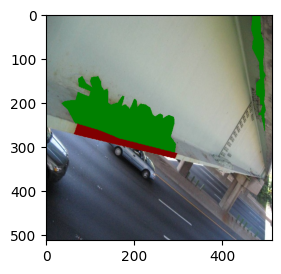

In [7]:
# 2控制 bg_org, depth
# pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth]).to(device)
# generator = torch.Generator(device=device).manual_seed(seed)
# pipeline.unet.use_freeu = True
loss_type = 'corrosion_ssim_loss_with_depth_ssim_loss'
pipeline.unet.use_freeu = False
controlnet_conditioning_scale_list=[1.0,1.0]
save_dir = f'/home/ubunto/Project/konglx/generate/diffusers/results/corrosion_and_crack/corrosion/diffusion/corrosion_with_background_for_test_bg_depth_input=2_without_freeu_seed=2024_{scheduler_setting}_{loss_type}'
# save_dir = None
os.makedirs(save_dir, exist_ok=True)
# image_name = '4'

for id, img_name in enumerate(img_dir_list):
    img_name = img_name.split('.')[0]
    print(f'{id+1}:Generating image for {img_name}')
    # if img_name != f'{image_name}':
    #     continue
    # mask_corrosion_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion/conditioning_images/{img_name}.png'
    mask_corrosion_with_bg_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/conditioning_images/{img_name}.png'
    # mask_members_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/output_infer_elements_imgs_ssr101_semi_model/{img_name}.png'
    mask_depth_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth/conditioning_images/{img_name}.png'
    # org_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/images_with_open_source_no_corrosion/{img_name}.jpg'
    # if mask_members_dir is not None and org_dir is not None and mask_depth_dir is not None:
    try:

        # mask_members_pil = load_image(mask_members_dir)
        # mask_members_pil_P = Image.open(mask_members_dir)
        # mask_members_np_P = np.array(mask_members_pil_P)
        # result_e, result_mask_e, on_member_num = generate_ellipses(arr=mask_members_np_P, num_ellipses=3, split_everywhere=False, gather_num=3)
        # filted_corrosion_arr = judge_if_corrosion_in_element(corrosion_arr=result_mask_e, element_arr=mask_members_np_demo, element_type=on_member_num)
        # filted_corrosion_colored_pil = colored_mask(filted_corrosion_arr)
        # filted_corrosion_colored_pil.save(os.path.join(save_dir, f'{img_name}_filted_corrosion.png'))
        
        # mask_corrosion_pil = load_image(mask_corrosion_dir)
        mask_corrosion_with_bg_pil = load_image(mask_corrosion_with_bg_dir)
        # print(mask_corrosion_pil.mode)
        plt.subplot(121)
        plt.imshow(mask_corrosion_with_bg_pil)

        mask_depth_pil = load_image(mask_depth_dir)
        # org_pil = load_image(org_dir)
        validation_image = [mask_corrosion_with_bg_pil, mask_depth_pil]
        image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list
                        ).images[0]
        # print(f'Generated image for {img_name}')
        if save_dir is not None:
            image.save(os.path.join(save_dir, f'{img_name}.jpg'))
        # plt.subplot(122)
        # plt.imshow(image)
        # plt.show()
    # else:
    #     print(img_name)
    except Exception as e:
        print(f'No image found for {img_name}!')
        print(e)
        pass
    continue
    # plt.figure(figsize=(20, 5))
    # plt.subplot(151)
    # plt.imshow(mask_corrosion_pil)
    # plt.subplot(152)
    # plt.imshow(mask_members_pil)
    # print(mask_members_pil.mode)
    # plt.subplot(153)
    # plt.imshow(mask_depth_pil)
    # print(mask_depth_pil.mode)
    # plt.subplot(154)
    # plt.imshow(org_img_pil)
    # plt.subplot(155)
    # plt.imshow(image)
    # plt.show()
# 无members，无corrosion，无depth
# else:
#     print('Input nothing')
# image

In [6]:
save_dir = f'/home/ubunto/Project/konglx/generate/diffusers/results/corrosion_and_crack/corrosion/diffusion/corrosion_with_background_for_test_bg_depth_input=2_with_freeu_seed={seed}_this'
# save_dir = None
os.makedirs(save_dir, exist_ok=True)


# 2控制 bg_org, depth
pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_depth],safety_checker=None,).to(device)
generator = torch.Generator(device=device).manual_seed(seed)
pipeline.unet.use_freeu = True
# pipeline.unet.use_freeu = False
controlnet_conditioning_scale_list=[1.0,1.0]
for id, img_name in enumerate(img_dir_list):
    img_name = img_name.split('.')[0]
    print(f'{id+1}:Generating image for {img_name}')
    # if img_name != f'{image_name}':
    #     continue
    # mask_corrosion_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion/conditioning_images/{img_name}.png'
    mask_corrosion_with_bg_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/conditioning_images/{img_name}.png'
    # mask_members_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/output_infer_elements_imgs_ssr101_semi_model/{img_name}.png'
    mask_depth_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth/conditioning_images/{img_name}.png'
    # org_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/images_with_open_source_no_corrosion/{img_name}.jpg'
    # if mask_members_dir is not None and org_dir is not None and mask_depth_dir is not None:
    try:

        # mask_members_pil = load_image(mask_members_dir)
        # mask_members_pil_P = Image.open(mask_members_dir)
        # mask_members_np_P = np.array(mask_members_pil_P)
        # result_e, result_mask_e, on_member_num = generate_ellipses(arr=mask_members_np_P, num_ellipses=3, split_everywhere=False, gather_num=3)
        # filted_corrosion_arr = judge_if_corrosion_in_element(corrosion_arr=result_mask_e, element_arr=mask_members_np_demo, element_type=on_member_num)
        # filted_corrosion_colored_pil = colored_mask(filted_corrosion_arr)
        # filted_corrosion_colored_pil.save(os.path.join(save_dir, f'{img_name}_filted_corrosion.png'))
        
        # mask_corrosion_pil = load_image(mask_corrosion_dir)
        mask_corrosion_with_bg_pil = load_image(mask_corrosion_with_bg_dir)
        # print(mask_corrosion_pil.mode)
        # plt.subplot(121)
        # plt.imshow(mask_corrosion_pil)

        mask_depth_pil = load_image(mask_depth_dir)
        # org_pil = load_image(org_dir)
        validation_image = [mask_corrosion_with_bg_pil, mask_depth_pil]
        image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list
                        ).images[0]
        # print(f'Generated image for {img_name}')
        if save_dir is not None:
            image.save(os.path.join(save_dir, f'{img_name}.jpg'))
        # plt.subplot(122)
        # plt.imshow(image)
        # plt.show()
    # else:
    #     print(img_name)
    except Exception as e:
        print(f'No image found for {img_name}!')
        print(e)
        pass
    continue
    # plt.figure(figsize=(20, 5))
    # plt.subplot(151)
    # plt.imshow(mask_corrosion_pil)
    # plt.subplot(152)
    # plt.imshow(mask_members_pil)
    # print(mask_members_pil.mode)
    # plt.subplot(153)
    # plt.imshow(mask_depth_pil)
    # print(mask_depth_pil.mode)
    # plt.subplot(154)
    # plt.imshow(org_img_pil)
    # plt.subplot(155)
    # plt.imshow(image)
    # plt.show()
# 无members，无corrosion，无depth
# else:
#     print('Input nothing')
# image

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


1:Generating image for 337


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:05,  3.74it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.76it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:02,  7.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:01<00:01,  7.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.52it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  7.58it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.63it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  7.66it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.67it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  7.61it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.61it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:02<00:00,  7.62it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.65it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  7.66it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.68it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  7.70it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.31it/s]


2:Generating image for 330


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.51it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.59it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.70it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.78it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.46it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
3:Generating image for 3__1__1848___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.67it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.67it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.12it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.50it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
4:Generating image for 1__1__2772___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.70it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.00it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
5:Generating image for 3__1__0___1976


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.96it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.50it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.51it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.51it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


6:Generating image for 0035


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.75it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.06it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:02<00:00,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
7:Generating image for 1__1__924___2772


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.51it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.00it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.53it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
8:Generating image for 1__1__3696___1848


  5%|▌         | 1/20 [00:00<00:04,  4.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.98it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.77it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
9:Generating image for 73


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.71it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.58it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.11it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
10:Generating image for 18__1__0___1848


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.96it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.20it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.00it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.75it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.88it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
11:Generating image for 18__1__1848___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.12it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.65it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.10it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.22it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.97it/s]


12:Generating image for 203


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.06it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.29it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
13:Generating image for 75


  5%|▌         | 1/20 [00:00<00:04,  4.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.22it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.00it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
14:Generating image for 230


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.77it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.00it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


15:Generating image for 18__1__924___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.96it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.78it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
16:Generating image for 209


  5%|▌         | 1/20 [00:00<00:04,  4.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.61it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.19it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
17:Generating image for 206


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.86it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.60it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  7.98it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.00it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
18:Generating image for 2__1__0___924


  5%|▌         | 1/20 [00:00<00:04,  4.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.20it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.09it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
19:Generating image for 218


  5%|▌         | 1/20 [00:00<00:04,  4.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.96it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.67it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.77it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.99it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
20:Generating image for 1__1__3696___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.96it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.50it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.19it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.29it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:01<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.10it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


21:Generating image for 222


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.19it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
22:Generating image for 2__1__2772___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


23:Generating image for 224


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
24:Generating image for 2__1__1848___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


25:Generating image for 2__1__0___1976


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.96it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.09it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
26:Generating image for 201


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


27:Generating image for 74


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
28:Generating image for 18__1__1848___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


29:Generating image for 2__1__924___1976


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


30:Generating image for 00034


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.19it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.29it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:01<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


31:Generating image for 211


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.19it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
32:Generating image for 3


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.99it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.29it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


33:Generating image for 1__1__0___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


34:Generating image for 70


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


35:Generating image for 18__1__924___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
36:Generating image for 18__1__2976___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


37:Generating image for 204


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
38:Generating image for 1__1__3696___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


39:Generating image for 18__1__2976___1976


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
40:Generating image for 0004


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


41:Generating image for 18__1__924___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
42:Generating image for 334


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


43:Generating image for 2__1__924___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


44:Generating image for 18__1__1848___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


45:Generating image for 1__1__4256___2932


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
46:Generating image for 335


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


47:Generating image for 31


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


48:Generating image for 228


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
49:Generating image for 2__1__2976___0


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.86it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.70it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
50:Generating image for 0030


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.57it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.69it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  7.73it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


51:Generating image for 2__1__1848___1976


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.76it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.99it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.29it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


52:Generating image for 0002


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.88it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  7.97it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
53:Generating image for 3__1__2976___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.55it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.59it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.67it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.74it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.76it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.78it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.44it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
54:Generating image for 00033


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.55it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.62it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.70it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.77it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
55:Generating image for 3__1__1848___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.55it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.64it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.74it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.73it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.74it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.66it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.39it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
56:Generating image for 4


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.75it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.14it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
57:Generating image for 00003


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.64it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.20it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.60it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.70it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.23it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
58:Generating image for 1__1__4256___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.55it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.50it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.55it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.70it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.76it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.75it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.36it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
59:Generating image for 1__1__4256___2772


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.57it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.67it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.74it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.76it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.66it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.65it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.35it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
60:Generating image for 3__1__2976___1976


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.51it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.84it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.60it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.72it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.78it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.44it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
61:Generating image for 00039


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.54it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.61it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.65it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.65it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.64it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.29it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
62:Generating image for 3__1__2772___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.71it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.55it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.84it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.28it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
63:Generating image for 1__1__1848___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.53it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.53it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  7.98it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.86it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.98it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.65it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
64:Generating image for 2__1__0___1848


  5%|▌         | 1/20 [00:00<00:04,  4.22it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  7.97it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.00it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.88it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.76it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
65:Generating image for 3__1__924___1976


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.22it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  6.00it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


66:Generating image for 00031


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
67:Generating image for 0003


  5%|▌         | 1/20 [00:00<00:04,  4.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
68:Generating image for 214


  5%|▌         | 1/20 [00:00<00:04,  4.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
69:Generating image for 18__1__0___1976


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


70:Generating image for 00002


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
71:Generating image for IMG_20231107_144349


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


72:Generating image for 36


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
73:Generating image for 0032


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


74:Generating image for 2__1__2976___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
75:Generating image for 3__1__0___924


  5%|▌         | 1/20 [00:00<00:04,  4.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
76:Generating image for 18__1__2772___924


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
77:Generating image for 207


  5%|▌         | 1/20 [00:00<00:04,  4.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
78:Generating image for 215


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
79:Generating image for 219


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


80:Generating image for 18__1__2772___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.99it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
81:Generating image for 340


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.69it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.67it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
82:Generating image for 30


  5%|▌         | 1/20 [00:00<00:04,  4.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.99it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.10it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.70it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
83:Generating image for 0034


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  7.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
84:Generating image for 18__1__1848___1976


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.66it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:02,  7.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.96it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  7.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.78it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  7.75it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.20it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.69it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


85:Generating image for 2__1__924___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.71it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.50it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.72it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.19it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
86:Generating image for 18__1__0___0


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.04it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
87:Generating image for 202


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.73it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.01it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
88:Generating image for 1__1__0___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.53it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.58it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.87it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.86it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
89:Generating image for 1__1__924___2932


  5%|▌         | 1/20 [00:00<00:04,  4.22it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.20it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.68it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.87it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.97it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.73it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
90:Generating image for 1__1__1848___2932


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.69it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.64it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.11it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.10it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.73it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
91:Generating image for 34


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.72it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.55it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.65it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.58it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.59it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
92:Generating image for 332


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
93:Generating image for 3__1__2772___1976


  5%|▌         | 1/20 [00:00<00:04,  4.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
94:Generating image for 229


  5%|▌         | 1/20 [00:00<00:04,  4.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.78it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
95:Generating image for 18


  5%|▌         | 1/20 [00:00<00:04,  4.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.29it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
96:Generating image for 18__1__2772___1976


  5%|▌         | 1/20 [00:00<00:04,  4.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.78it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
97:Generating image for 19


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.04it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
98:Generating image for 2__1__2976___1848


  5%|▌         | 1/20 [00:00<00:04,  4.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.12it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.97it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
99:Generating image for 2__1__0___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.72it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.61it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.65it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.00it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
100:Generating image for 32


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:02,  7.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.62it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.99it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.29it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
101:Generating image for 00019


  5%|▌         | 1/20 [00:00<00:04,  4.19it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.87it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.10it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  7.87it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.20it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.88it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
102:Generating image for 0018


  5%|▌         | 1/20 [00:00<00:04,  4.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.10it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.61it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.86it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.71it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  7.96it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.88it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
103:Generating image for 208


  5%|▌         | 1/20 [00:00<00:04,  4.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.87it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.55it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.69it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.86it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.11it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
104:Generating image for 1__1__1848___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.84it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.99it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.99it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.68it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
105:Generating image for 1__1__924___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.65it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  7.99it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.12it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
106:Generating image for 2__1__1848___1848


  5%|▌         | 1/20 [00:00<00:04,  4.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
107:Generating image for 225


  5%|▌         | 1/20 [00:00<00:04,  4.22it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
108:Generating image for 3__1__924___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


109:Generating image for 1__1__2772___2772


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
110:Generating image for 1__1__924___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


111:Generating image for 1__1__3696___2772


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
112:Generating image for 1__1__4256___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


113:Generating image for 1__1__2772___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
114:Generating image for 00032


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


115:Generating image for 2__1__2772___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
116:Generating image for 3__1__2976___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


117:Generating image for 00035


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


118:Generating image for 1__1__0___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


119:Generating image for 18__1__924___1976


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
120:Generating image for 221


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


121:Generating image for 2__1__2772___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
122:Generating image for 200


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.00it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


123:Generating image for 339


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
124:Generating image for 2__1__924___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.00it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


125:Generating image for 00001


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
126:Generating image for 220


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


127:Generating image for 0033


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
128:Generating image for 33


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


129:Generating image for 205


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.78it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
130:Generating image for 18__1__2772___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


131:Generating image for 3__1__924___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
132:Generating image for 226


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
133:Generating image for 00036


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
134:Generating image for 1__1__2772___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


135:Generating image for 227


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
136:Generating image for 3__1__2772___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.96it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.50it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


137:Generating image for 1__1__4256___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
138:Generating image for 3__1__924___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


139:Generating image for 00004


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
140:Generating image for 18__1__0___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


141:Generating image for 1__1__924___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
142:Generating image for 2__1__2772___1976


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


143:Generating image for 18__1__2976___0


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
144:Generating image for 3__1__0___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.49it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.00it/s]


145:Generating image for 3__1__2976___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.64it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.97it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  7.97it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.12it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
146:Generating image for 1__1__0___2932


  5%|▌         | 1/20 [00:00<00:04,  4.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.97it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.20it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.00it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
147:Generating image for 38


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.68it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.51it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.67it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.77it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.84it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.19it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
148:Generating image for 36_T


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.58it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:02,  7.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.00it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.98it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.71it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
149:Generating image for 217


  5%|▌         | 1/20 [00:00<00:04,  4.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.52it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.63it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.20it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
150:Generating image for 213


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.62it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.64it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
151:Generating image for 1__1__2772___2932


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.71it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.00it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  7.98it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.22it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
152:Generating image for 336


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  7.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


153:Generating image for 3__1__1848___1848


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.65it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
154:Generating image for 331


  5%|▌         | 1/20 [00:00<00:04,  4.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.71it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.06it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.03it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.10it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.73it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
155:Generating image for 0031


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.69it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.59it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.19it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.11it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.77it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
156:Generating image for 2


  5%|▌         | 1/20 [00:00<00:04,  4.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.68it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.87it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.29it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
157:Generating image for 3__1__2772___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.69it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  7.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
158:Generating image for 18__1__2976___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.22it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.70it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.86it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.34it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
159:Generating image for 0019


  5%|▌         | 1/20 [00:00<00:04,  4.22it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.88it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.76it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.97it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
160:Generating image for 1__1__1848___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:02,  6.02it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.90it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:02,  7.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.53it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.97it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.11it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.86it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


161:Generating image for 1__1__0___2772


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.71it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.66it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.29it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.98it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
162:Generating image for 00038


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.73it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.01it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  7.98it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.22it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.19it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


163:Generating image for 39


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.86it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.76it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
164:Generating image for 1__1__3696___2932


  5%|▌         | 1/20 [00:00<00:04,  4.20it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.74it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.29it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
165:Generating image for 212


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.79it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.29it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.01it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
166:Generating image for 37


  5%|▌         | 1/20 [00:00<00:04,  4.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.78it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.97it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.20it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
167:Generating image for 2__1__2976___1976


  5%|▌         | 1/20 [00:00<00:04,  4.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.54it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.69it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.04it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.97it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.73it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
168:Generating image for 333


  5%|▌         | 1/20 [00:00<00:04,  4.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.72it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.10it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
169:Generating image for 2__1__1848___924


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.35it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.00it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
170:Generating image for 223


  5%|▌         | 1/20 [00:00<00:04,  4.16it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.67it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.09it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.18it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.21it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
171:Generating image for 338


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.58it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  7.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.12it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.06it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.88it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  7.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  7.86it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
172:Generating image for 00037


  5%|▌         | 1/20 [00:00<00:04,  4.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.84it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.66it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.83it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.84it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
173:Generating image for 216


  5%|▌         | 1/20 [00:00<00:04,  4.22it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.91it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.71it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.10it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.29it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.42it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  8.00it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
174:Generating image for 72


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.10it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.72it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.52it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  6.98it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:02,  7.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.43it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:01<00:01,  7.57it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.64it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  7.69it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.71it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  7.64it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  7.61it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:01<00:00,  7.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:02<00:00,  7.85it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.06it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.19it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.60it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


175:Generating image for 71


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  7.93it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  7.92it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
176:Generating image for 1__1__1848___2772


  5%|▌         | 1/20 [00:00<00:04,  4.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.08it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.26it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.27it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.24it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.97it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
177:Generating image for 35


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  5%|▌         | 1/20 [00:00<00:04,  4.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  5.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.88it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.66it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:00<00:01,  7.82it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.07it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.23it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:00,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.30it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.41it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.95it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


178:Generating image for 210


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.94it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.76it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  8.00it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.28it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.36it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
179:Generating image for 00018


  5%|▌         | 1/20 [00:00<00:04,  4.14it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.80it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  7.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  7.89it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.12it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.31it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 95%|█████████▌| 19/20 [00:02<00:00,  8.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
180:Generating image for 00030


  5%|▌         | 1/20 [00:00<00:04,  4.15it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 15%|█▌        | 3/20 [00:00<00:02,  6.81it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 25%|██▌       | 5/20 [00:00<00:01,  7.75it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 35%|███▌      | 7/20 [00:00<00:01,  8.13it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 45%|████▌     | 9/20 [00:01<00:01,  8.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 55%|█████▌    | 11/20 [00:01<00:01,  8.38it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 65%|██████▌   | 13/20 [00:01<00:00,  8.44it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 75%|███████▌  | 15/20 [00:01<00:00,  8.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 85%|████████▌ | 17/20 [00:02<00:00,  8.47it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  8.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:02<00:00,  7.98it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  4.57it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  5.65it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:01<00:02,  6.05it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  6.25it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  6.32it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:02<00:01,  6.37it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:02<00:00,  6.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  6.39it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  6.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:03<00:00,  6.10it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
Generated image for 0002


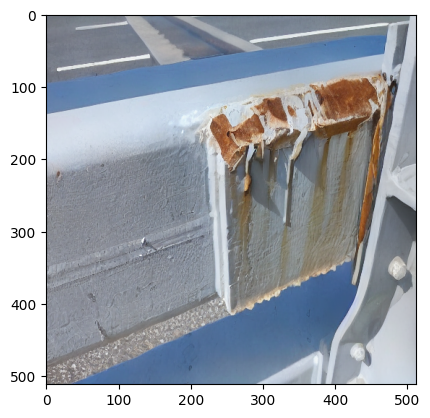

In [7]:
# 2控制bg_org, , depth
pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_corrosion, controlnet_depth]).to(device)
generator = torch.Generator(device=device).manual_seed(seed)
pipeline.unet.use_freeu = True
controlnet_conditioning_scale_list=[1.0,0.0,1.0]
for img_name in img_dir_list:
    img_name = img_name.split('.')[0]
    if img_name != f'{image_name}':
        continue
    mask_corrosion_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion/conditioning_images/{img_name}.png'
    mask_corrosion_with_bg_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/conditioning_images/{img_name}.png'
    # mask_members_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/output_infer_elements_imgs_ssr101_semi_model/{img_name}.png'
    mask_depth_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth/conditioning_images/{img_name}.png'
    # org_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/images_with_open_source_no_corrosion/{img_name}.jpg'
    # if mask_members_dir is not None and org_dir is not None and mask_depth_dir is not None:
    try:

        # mask_members_pil = load_image(mask_members_dir)
        # mask_members_pil_P = Image.open(mask_members_dir)
        # mask_members_np_P = np.array(mask_members_pil_P)
        # result_e, result_mask_e, on_member_num = generate_ellipses(arr=mask_members_np_P, num_ellipses=3, split_everywhere=False, gather_num=3)
        # filted_corrosion_arr = judge_if_corrosion_in_element(corrosion_arr=result_mask_e, element_arr=mask_members_np_demo, element_type=on_member_num)
        # filted_corrosion_colored_pil = colored_mask(filted_corrosion_arr)
        # filted_corrosion_colored_pil.save(os.path.join(save_dir, f'{img_name}_filted_corrosion.png'))
        
        mask_corrosion_pil = load_image(mask_corrosion_dir)
        mask_corrosion_with_bg_pil = load_image(mask_corrosion_with_bg_dir)
        # print(mask_corrosion_pil.mode)
        # plt.subplot(121)
        # plt.imshow(mask_corrosion_pil)

        mask_depth_pil = load_image(mask_depth_dir)
        # org_pil = load_image(org_dir)
        validation_image = [mask_corrosion_with_bg_pil, mask_corrosion_pil, mask_depth_pil]
        image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list
                        ).images[0]
        print(f'Generated image for {img_name}')
        # if save_dir is not None:
        #     image.save(os.path.join(save_dir, f'{img_name}.jpg'))
        # plt.subplot(122)
        plt.imshow(image)
        plt.show()
    # else:
    #     print(img_name)
    except Exception as e:
        print(f'No image found for {img_name}!')
        print(e)
        pass
    continue
    # plt.figure(figsize=(20, 5))
    # plt.subplot(151)
    # plt.imshow(mask_corrosion_pil)
    # plt.subplot(152)
    # plt.imshow(mask_members_pil)
    # print(mask_members_pil.mode)
    # plt.subplot(153)
    # plt.imshow(mask_depth_pil)
    # print(mask_depth_pil.mode)
    # plt.subplot(154)
    # plt.imshow(org_img_pil)
    # plt.subplot(155)
    # plt.imshow(image)
    # plt.show()
# 无members，无corrosion，无depth
# else:
#     print('Input nothing')
# image

  0%|          | 0/20 [00:00<?, ?it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 10%|█         | 2/20 [00:00<00:03,  4.63it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 20%|██        | 4/20 [00:00<00:02,  5.77it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 30%|███       | 6/20 [00:01<00:02,  6.17it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 40%|████      | 8/20 [00:01<00:01,  6.33it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 50%|█████     | 10/20 [00:01<00:01,  6.40it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 60%|██████    | 12/20 [00:01<00:01,  6.46it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 70%|███████   | 14/20 [00:02<00:00,  6.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 80%|████████  | 16/20 [00:02<00:00,  6.45it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


 90%|█████████ | 18/20 [00:02<00:00,  6.48it/s]

self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2


100%|██████████| 20/20 [00:03<00:00,  6.19it/s]


self.use_freeu and not self.use_freeu and not self.use_wavelet: True
1.3 1.6 0.6 0.2
Generated image for 0002


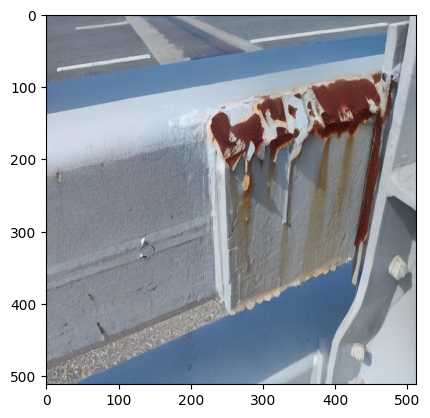

In [10]:
# 3控制bg_org, corrosion, depth
pipeline = StableDiffusionControlNetPipeline.from_pretrained(config_dir, controlnet=[controlnet_corrosion_with_bg, controlnet_corrosion, controlnet_depth]).to(device)
generator = torch.Generator(device=device).manual_seed(seed)
pipeline.unet.use_freeu = True
controlnet_conditioning_scale_list=[1.0,0.5,1.0]
for img_name in img_dir_list:
    img_name = img_name.split('.')[0]
    if img_name != f'{image_name}':
        continue
    mask_corrosion_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion/conditioning_images/{img_name}.png'
    mask_corrosion_with_bg_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/corrosion_with_background_for_test/conditioning_images/{img_name}.png'
    # mask_members_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/output_infer_elements_imgs_ssr101_semi_model/{img_name}.png'
    mask_depth_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth/conditioning_images/{img_name}.png'
    # org_dir = f'/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/depth_no_corrosion/add_opensource_no_corrosion/images_with_open_source_no_corrosion/{img_name}.jpg'
    # if mask_members_dir is not None and org_dir is not None and mask_depth_dir is not None:
    try:

        # mask_members_pil = load_image(mask_members_dir)
        # mask_members_pil_P = Image.open(mask_members_dir)
        # mask_members_np_P = np.array(mask_members_pil_P)
        # result_e, result_mask_e, on_member_num = generate_ellipses(arr=mask_members_np_P, num_ellipses=3, split_everywhere=False, gather_num=3)
        # filted_corrosion_arr = judge_if_corrosion_in_element(corrosion_arr=result_mask_e, element_arr=mask_members_np_demo, element_type=on_member_num)
        # filted_corrosion_colored_pil = colored_mask(filted_corrosion_arr)
        # filted_corrosion_colored_pil.save(os.path.join(save_dir, f'{img_name}_filted_corrosion.png'))
        
        mask_corrosion_pil = load_image(mask_corrosion_dir)
        mask_corrosion_with_bg_pil = load_image(mask_corrosion_with_bg_dir)
        # print(mask_corrosion_pil.mode)
        # plt.subplot(121)
        # plt.imshow(mask_corrosion_pil)

        mask_depth_pil = load_image(mask_depth_dir)
        # org_pil = load_image(org_dir)
        validation_image = [mask_corrosion_with_bg_pil, mask_corrosion_pil, mask_depth_pil]
        image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator, controlnet_conditioning_scale=controlnet_conditioning_scale_list
                        ).images[0]
        print(f'Generated image for {img_name}')
        # if save_dir is not None:
        #     image.save(os.path.join(save_dir, f'{img_name}.jpg'))
        # plt.subplot(122)
        plt.imshow(image)
        plt.show()
    # else:
    #     print(img_name)
    except Exception as e:
        print(f'No image found for {img_name}!')
        print(e)
        pass
    continue
    # plt.figure(figsize=(20, 5))
    # plt.subplot(151)
    # plt.imshow(mask_corrosion_pil)
    # plt.subplot(152)
    # plt.imshow(mask_members_pil)
    # print(mask_members_pil.mode)
    # plt.subplot(153)
    # plt.imshow(mask_depth_pil)
    # print(mask_depth_pil.mode)
    # plt.subplot(154)
    # plt.imshow(org_img_pil)
    # plt.subplot(155)
    # plt.imshow(image)
    # plt.show()
# 无members，无corrosion，无depth
# else:
#     print('Input nothing')
# image

/tmp/ipykernel_1807666/3625383228.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  point = plt.ginput(n=1, show_clicks=True)


KeyboardInterrupt: 

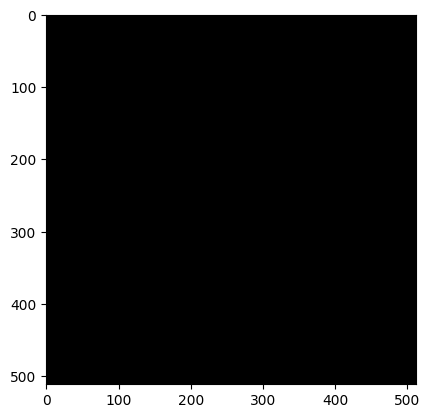

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# 定义图像数组和绘制色值
img = np.zeros((512,512),dtype=np.uint8)
draw_value = 255

# 打开交互模式
plt.ion()

# 初始化显示
plt.imshow(img,cmap='gray')

while True:

  # 获取鼠标点击点
  point = plt.ginput(n=1, show_clicks=True)  

  # 转换为整数坐标
  x,y = map(int,point[0])

  # 限制在图像范围内 
  x = max(0, min(x, img.shape[0]-1))
  y = max(0, min(y, img.shape[1]-1))

  # 在点位置绘制
  img[x,y] = draw_value

  # 更新显示
  plt.imshow(img,cmap='gray')
  plt.draw()

  print('Drawing at:', x,y)

# 关闭交互模式  
plt.ioff()

In [18]:
mask_corrosion_np = np.array(mask_corrosion_pil)
mask_corrosion_np.min(), mask_corrosion_np.max(), mask_corrosion_np.shape

(0, 128, (512, 512, 3))

In [ ]:
# if mask_members_dir is not None and mask_corrosion_dir is None:

#     plt.figure(figsize=(16, 8))
#     plt.subplot(121)
#     plt.imshow(mask_members_pil)
#     plt.subplot(122)
#     plt.imshow(image)
#     plt.show()
#     # Image.show(image)
    
# elif mask_members_dir is  None and mask_corrosion_dir is not None:

#     plt.figure(figsize=(16, 8))
#     plt.subplot(121)
#     plt.imshow(mask_corrosion_pil)
#     plt.subplot(122)
#     plt.imshow(image)
#     plt.show()
# else:

#     plt.figure(figsize=(16, 8))
#     plt.subplot(131)
#     plt.imshow(mask_corrosion_pil)
#     plt.subplot(132)
#     plt.imshow(mask_members_pil)
#     plt.subplot(133)
#     plt.imshow(image)
#     plt.show()

## PNDM

In [ ]:
# PNDMScheduler
generator = torch.Generator(device=device).manual_seed(seed)
image = pipeline(prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

## DDPM

In [ ]:
# DDPMScheduler
from diffusers import DDPMScheduler
import os
generator = torch.Generator(device=device).manual_seed(seed)
scheduler_ddpm = DDPMScheduler.from_pretrained(os.path.join(config_dir, 'scheduler'))

# print(pipeline.scheduler)
pipeline.scheduler = scheduler_ddpm
# print(pipeline.scheduler)
image = pipeline(
                   prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

In [ ]:
if mask_members_dir is not None and mask_corrosion_dir is None:

    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_members_pil)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
    # Image.show(image)
    
elif mask_members_dir is  None and mask_corrosion_dir is not None:

    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.imshow(mask_corrosion_pil)
    plt.subplot(132)
    plt.imshow(org_img_pil)
    plt.subplot(133)
    plt.imshow(image)
    plt.show()
else:

    plt.figure(figsize=(16, 8))
    plt.subplot(141)
    plt.imshow(mask_corrosion_pil)
    plt.subplot(142)
    plt.imshow(mask_members_pil)
    plt.subplot(143)
    plt.imshow(org_img_pil)
    plt.subplot(144)
    plt.imshow(image)
    plt.show()

## DDIM

In [ ]:
# DDIMScheduler
from diffusers import DDIMScheduler
import os
generator = torch.Generator(device=device).manual_seed(seed)
scheduler_ddim = DDIMScheduler.from_pretrained(os.path.join(config_dir, 'scheduler'))

print(pipeline.scheduler)
pipeline.scheduler = scheduler_ddim
print(pipeline.scheduler)
image = pipeline(
                   prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

## PNDM

In [ ]:
# PNDMScheduler
from diffusers import PNDMScheduler
import os
generator = torch.Generator(device=device).manual_seed(seed)
scheduler_pndm = PNDMScheduler.from_pretrained(os.path.join(config_dir, 'scheduler'))

print(pipeline.scheduler)
pipeline.scheduler = scheduler_pndm
print(pipeline.scheduler)
image = pipeline(
                   prompt, validation_image, num_inference_steps=20, generator=generator
                ).images[0]
image

# ***##step by step denoise##***

In [ ]:

control_dir = '/home/ubunto/Project/konglx/generate/diffusers/examples/controlnet/controlnet-model_crack_only_generate/checkpoint-2000/controlnet'
config_dir = '/home/ubunto/Project/konglx/generate/ControlNet/models/stable-diffusion-v1-5'

## 1.创建各个部分的模型

In [ ]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, ControlNetModel
import os

vae = AutoencoderKL.from_pretrained(config_dir, subfolder='vae', use_safetensors=None)
tokenizer = CLIPTokenizer.from_pretrained(config_dir, subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained(config_dir, subfolder='text_encoder', use_safetensors=None)
unet = UNet2DConditionModel.from_pretrained(config_dir, subfolder='unet', use_safetensors=None)

controlnet = ControlNetModel.from_pretrained(control_dir)
controlnet.config

In [ ]:
vae.config.scaling_factor

In [ ]:
from diffusers import UniPCMultistepScheduler

scheduler_multistep = UniPCMultistepScheduler.from_pretrained(config_dir, subfolder="scheduler")
scheduler_multistep

In [ ]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)
controlnet.to(torch_device)
unet.config

## 2.Create embeddings

### 2.1 Create text embeddings

In [ ]:
prompt = ["crack"]
device = 'cuda'
seed = 0
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.Generator(device=device).manual_seed(seed)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [ ]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

prompt_embeds = text_embeddings
encoder_hidden_states_control = text_embeddings
text_embeddings.shape

### 2.2 Create image embeddings

In [ ]:
from torchvision import transforms

mask_dir = '/home/ubunto/Project/konglx/generate/diffusers/datasets/corrosion_and_crack/crack（复件）/SegmentationClass/DeepCrack_11240-6.png'
validation_image = Image.open(mask_dir).convert("RGB")
validation_image.size

conditioning_image_transforms = transforms.Compose(
        [
            transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(512),
            transforms.ToTensor(),
        ]
    )


conditioning_image_pil = validation_image.resize([512, 512])
conditioning_pixel_values = torch.stack([conditioning_image_transforms(conditioning_image_pil)])
conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()
print(conditioning_pixel_values.shape)
controlnet_image = conditioning_pixel_values.to(torch_device)
# print(controlnet_image)
conditioning_image_pil

In [ ]:
'''
You’ll also need to generate the unconditional text embeddings which are the embeddings for the padding token.
These need to have the same shape (batch_size and seq_length) as the conditional text_embeddings:
'''
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
uncond_embeddings.shape, text_embeddings.shape

In [ ]:
# Let’s concatenate the conditional and unconditional embeddings into a batch to avoid doing two forward passes:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
# text_embeddings
text_embeddings.shape

## 3.Create random noise

In [ ]:
''' 
Next, generate some initial random noise as a starting point for the diffusion process. 
This is the latent representation of the image, and it’ll be gradually denoised. 
At this point, the latent image is smaller than the final image size but that’s okay though 
because the model will transform it into the final 512x512 image dimensions later.
'''

# The height and width are divided by 8 because the vae model has 3 down-sampling layers.
# You can check by running the following:   2 ** (len(vae.config.block_out_channels) - 1) == 8

do_classifier_free_guidance = False
guess_mode = False

latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)



latents.shape

In [ ]:
down_block_res_samples, mid_block_res_sample = controlnet(
                    latents,
                    2,
                    encoder_hidden_states=encoder_hidden_states_control,
                    controlnet_cond=controlnet_image,
                    return_dict=False,
                )
len(down_block_res_samples), down_block_res_samples[-1].shape, len(mid_block_res_sample), mid_block_res_sample[0].shape

## 4.Denoise the image

In [ ]:
'''
Start by scaling the input with the initial noise distribution, sigma, the noise scale value, 
which is required for improved schedulers like UniPCMultistepScheduler: 
'''
print(scheduler_multistep.init_noise_sigma)
latents = latents * scheduler_multistep.init_noise_sigma
latents.shape

In [ ]:
''' 
The last step is to create the denoising loop that’ll progressively 
transform the pure noise in latents to an image described by your prompt.
Remember, the denoising loop needs to do three things:

1.Set the scheduler’s timesteps to use during denoising.
2.Iterate over the timesteps.
3.At each timestep, call the UNet model to predict the noise residual and 
pass it to the scheduler to compute the previous noisy sample.

'''

from tqdm.auto import tqdm

scheduler_multistep.set_timesteps(num_inference_steps)

for t in tqdm(scheduler_multistep.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler_multistep.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler_multistep.step(noise_pred, t, latents).prev_sample

In [ ]:
from PIL import Image
from torchvision import transforms

pil_latents = transforms.ToPILImage()(latents.squeeze(0))
pil_latents


## 5.Decode the image

In [ ]:
# scale and decode the image latents with vae
latents_scaled = 1 / vae.config.scaling_factor * latents
# pil_latents_scaled = transforms.ToPILImage()(latents.squeeze(0))
# pil_latents_scaled = transforms.ToPILImage()(latents_scaled.squeeze(0))
with torch.no_grad():
    # image = vae.decode(latents).sample
    image = vae.decode(latents_scaled).sample
print(image.shape)



In [ ]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

In [ ]:
''' 
The last step is to create the denoising loop that’ll progressively 
transform the pure noise in latents to an image described by your prompt.
Remember, the denoising loop needs to do three things:

1.Set the scheduler’s timesteps to use during denoising.
2.Iterate over the timesteps.
3.At each timestep, call the UNet model to predict the noise residual and 
pass it to the scheduler to compute the previous noisy sample.

'''

from tqdm.auto import tqdm

scheduler_multistep.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    # expand the latents if we are doing classifier free guidance
    latent_model_input_control = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    # latent_model_input_control = torch.cat([latents_control] * 2)

    latent_model_input_control = scheduler.scale_model_input(latent_model_input_control, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred_control = unet(latent_model_input_control, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond_control, noise_pred_text_control = noise_pred_control.chunk(2)
    noise_pred_control = noise_pred_uncond_control+ guidance_scale * (noise_pred_text_control - noise_pred_uncond_control)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred_control, t, latents).prev_sample

In [ ]:
a = any
a in 'abc'